# Analysis of Alt-text use in mastodon.social by client

A project by [Cristal Rivera](https://linkedin.com/in/cristal-rivera-picado/) and [Tommaso Marmo](https://tommi.space/) to analyse the use of alt-text in [mastodon.social](https://mastodon.social/about), using [Stefan Bohacek](https://stefanbohacek.com/)’s <cite>[mastodon.social alt text use by client app](https://www.kaggle.com/datasets/fourtonfish/mastodon-social-alt-text-use-by-client-app)</cite> dataset, published on Kaggle under the [MIT license](https://www.mit.edu/~amini/LICENSE.md).

This analysis is being conducted as a group project for the [Introduction to Data Science](https://ois2.tlu.ee/tluois/subject/ULP6613-23265) course of the <cite>[Artificial Intelligence and Sustainable Societies](https://aissprogram.eu)</cite> master.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import and print dataset
data = pd.read_csv('./fediverse-client-alt-text-data-2024-05-13.csv')
data

,client,status_count,descriptions_all_count,descriptions_all_percent,descriptions_some_count,descriptions_some_percent,descriptions_none_count,descriptions_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000
...,...,...,...,...,...,...,...,...
261,socialbot,1,1,100.000000,0,0.000000,0,0.000000
262,PhonocasterMusicShare,1,0,0.000000,0,0.000000,1,100.000000
263,openvibe,1,0,0.000000,0,0.000000,1,100.000000
264,iflaapp,1,0,0.000000,0,0.000000,1,100.000000


## Data wrangling

In [3]:
print(f'Confirm data type of the dataset: {type(data)}')

Confirm data type of the dataset: <class 'pandas.core.frame.DataFrame'>


In [4]:
# Experimental example taken from ChatGPT
def summarize_dataframe(df):
    """
    Provides a summary of each column in the DataFrame, including:
    - Data type
    - Number of missing values
    - Number of unique values
    - Descriptive statistics (for numerical columns)
    
    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    """
    # Data type and count of missing values
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Unique Values': df.nunique()
    })
    
    # Descriptive statistics for numerical columns
    numerical_summary = df.describe().T
    summary = summary.merge(numerical_summary, left_index=True, right_index=True, how="left")
    
    # Display summary for categorical columns separately
    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_summary = df[categorical_columns].describe().T
    
    print("Summary of Numerical Columns:")
    display(summary)
    print("\nSummary of Categorical Columns:")
    display(categorical_summary)

summarize_dataframe(data)

Summary of Numerical Columns:


,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
client,object,0,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status_count,int64,0,80,266.0,112.240602,643.625189,1.0,2.0,8.0,39.75,8272.000000
descriptions_all_count,int64,0,45,266.0,21.473684,105.282555,0.0,0.0,0.0,4.00,1438.000000
descriptions_all_percent,float64,0,44,266.0,36.290411,45.079671,0.0,0.0,0.0,100.00,100.000000
descriptions_some_count,int64,0,6,266.0,0.093985,0.622382,0.0,0.0,0.0,0.00,7.000000
descriptions_some_percent,float64,0,12,266.0,0.060461,0.527118,0.0,0.0,0.0,0.00,7.142857
descriptions_none_count,int64,0,70,266.0,90.672932,568.477040,0.0,0.0,2.0,20.00,6827.000000
descriptions_none_percent,float64,0,44,266.0,63.649128,45.113843,0.0,0.0,100.0,100.00,100.000000



Summary of Categorical Columns:


,count,unique,top,freq
client,266,266,Today's Dérive app task,1


### Information about the dataset

In [5]:
# Tuple with number of rows and number of columns
data_rows, data_columns = data.shape
# Integer that is the result of n of columns * n of rows
data_size = data.size

print(f'Number of rows: {data_rows}\nNumber of columns: {data_columns}\nData size (rows*columns): {data_size}')

Number of rows: 266
Number of columns: 8
Data size (rows*columns): 2128


In [6]:
data.describe()

,status_count,descriptions_all_count,descriptions_all_percent,descriptions_some_count,descriptions_some_percent,descriptions_none_count,descriptions_none_percent
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,112.240602,21.473684,36.290411,0.093985,0.060461,90.672932,63.649128
std,643.625189,105.282555,45.079671,0.622382,0.527118,568.477040,45.113843
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,0.000000,2.000000,100.000000
75%,39.750000,4.000000,100.000000,0.000000,0.000000,20.000000,100.000000
max,8272.000000,1438.000000,100.000000,7.000000,7.142857,6827.000000,100.000000


In [7]:
# Check if there are any duplicated clients
any(data.duplicated())

False

In [8]:
# Check if there are any missing values in status_count
any(data.status_count.isnull())

False

In [9]:
# Sort clients by status_count
data = data.sort_values('status_count',ascending=False)

### Naming and understanding data fields

All columns correspond to relevant data, and to achieve this we will be going through each column, one by one, to understand its meaning and rename it in more explicatory name.

In [10]:
data = data.rename(columns={
    'status_count': 'posts_count',
    'descriptions_all_count': 'alttext_all_count',
    'descriptions_all_percent': 'alttext_all_percent',
    'descriptions_some_count': 'alttext_some_count',
    'descriptions_some_percent': 'alttext_some_percent',
    'descriptions_none_count': 'alttext_none_count',
    'descriptions_none_percent': 'alttext_none_percent'
})

## Data exploration

In [11]:
data.head()

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000


In [12]:
data.tail()

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
261,socialbot,1,1,100.0,0,0.0,0,0.0
262,PhonocasterMusicShare,1,0,0.0,0,0.0,1,100.0
263,openvibe,1,0,0.0,0,0.0,1,100.0
264,iflaapp,1,0,0.0,0,0.0,1,100.0
265,Today's Dérive app task,1,1,100.0,0,0.0,0,0.0


## General analysis

Get general information independently of the client used.

In [13]:
posts_count_total = data['posts_count'].sum()
alttext_all_count_total = data['alttext_all_count'].sum()
alttext_some_count_total = data['alttext_some_count'].sum()
alttext_none_count_total = data['alttext_none_count'].sum()

alttext_all_count_total_pct = round(alttext_all_count_total / posts_count_total * 100, 2)
alttext_some_count_total_pct = round(alttext_some_count_total / posts_count_total * 100, 2)
alttext_none_count_total_pct = round(alttext_none_count_total / posts_count_total * 100, 2)

if posts_count_total == alttext_all_count_total + alttext_some_count_total + alttext_none_count_total:
    print('Posts count is matching!')
else:
    print('Something is wrong in the dataset. Please revise the number of posts!')

print(f"""
Total number of posts under analysis: {posts_count_total}
    of which {alttext_all_count_total} ({alttext_all_count_total_pct}%) contain an alt-text for all images,
    {alttext_some_count_total} ({alttext_some_count_total_pct}%) for some,
    and {alttext_none_count_total} ({alttext_none_count_total_pct}%) have no alt-text at all.
""")

Posts count is matching!

Total number of posts under analysis: 29856
    of which 5712 (19.13%) contain an alt-text for all images,
    25 (0.08%) for some,
    and 24119 (80.78%) have no alt-text at all.



([<matplotlib.patches.Wedge at 0x7f18cf01cc20>,
 [Text(0.9072200614564419, 0.6220544671417207, 'Alt-text for all'),
  Text(0.39375079719851147, 1.0271126080939406, 'Alt-text for some'),
  Text(-0.9055803497641123, -0.6244391324389498, 'No alt-text')],
 [Text(0.4948473062489682, 0.3393024366227568, '19.1%'),
  Text(0.214773162108279, 0.560243240778513, '0.1%'),
  Text(-0.4939529180531521, -0.340603163148518, '80.8%')])

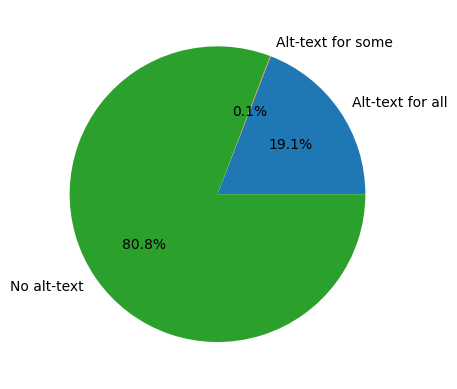

In [14]:
posts_pie = [alttext_all_count_total, alttext_some_count_total, alttext_none_count_total]
labels_pie = ['Alt-text for all', 'Alt-text for some', 'No alt-text']

fig, ax = plt.subplots()
ax.pie(posts_pie, labels=labels_pie, autopct='%1.1f%%')